In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from sympy import *

In [27]:
Ainit = 1e-5
kon = 1e4
rho = 1
k = kon*Ainit*rho
Target_cell_number = 5e3
Atot = 1e16*Ainit/Target_cell_number
rtot = 1e5
beta = Atot/rtot
koff = 1e-4
delta = 0.5

In [28]:
def func(x):
    return (2/rtot)*k*(rtot-x-(((delta/rtot)*k*(rtot-x)*x)/(koff+(delta/rtot)*k*x)))*(Atot-x-(((delta/rtot)*k*(rtot-x)*x)/(2*koff+2*(delta/rtot)*k*x))) - koff*x - (delta/rtot)*k*(rtot-x-(((delta/rtot)*k*(rtot-x)*x)/(koff+(delta/rtot)*k*x)))*x + 2*koff*(((delta/rtot)*k*(rtot-x)*x)/(2*koff+2*(delta/rtot)*k*x))

roots = fsolve(func, 1e3)
print(roots/rtot)

[0.99874437]


In [29]:
def func1(x):
    f1 = 2*(k/rtot)*(rtot-x[0]-2*x[1])*(Atot-x[0]-x[1]) - koff*x[0] - delta*(k/rtot)*(rtot-x[0]-2*x[1])*x[0] + 2*koff*x[1]
    f2 = delta*(k/rtot)*(rtot-x[0]-2*x[1])*x[0] - 2*koff*x[1]
    return [f1, f2]

roots = fsolve(func1, [0.9*rtot, 0.9*rtot])
print(roots/rtot) 

[9.98744366e-01 6.26562284e-04]


In [30]:
Target_cell_number = 5e3
Atot = 1e16*Ainit/Target_cell_number
rtot = 1e5
beta = Atot/rtot
delta = 4
gamma = 1

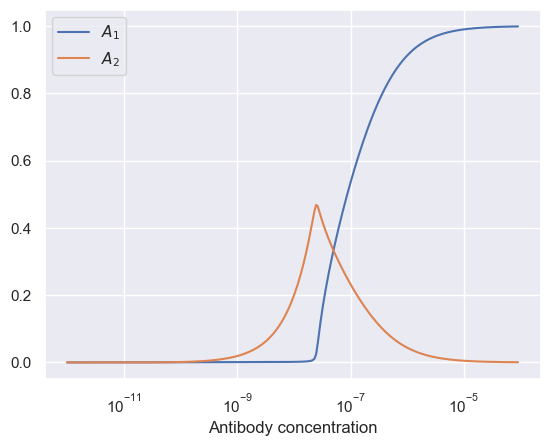

In [31]:
def dimensionless_model(t, z, A0, delta):
    k = kon*A0
    alpha = k/koff
    Atot = 1e16*A0/Target_cell_number
    beta = Atot/rtot
    dA1 = 2*alpha*(1-z[0]-2*z[1])*(beta-z[0]-z[1]) - gamma*z[0] - delta*alpha*(1-z[0]-2*z[1])*z[0] + 2*gamma*z[1]
    dA2 = delta*alpha*(1-z[0]-2*z[1])*z[0] - 2*gamma*z[1]

    return [dA1, dA2]

vals = np.linspace(1, 9, 50)

A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
A0s = []

for x in A0s1:
    for val in vals:
        A0s.append(x*val)

A1s = np.ones_like(A0s)
A2s = np.ones_like(A0s)

t_end = 100000
t = np.geomspace(1e-10, t_end, 5000)
tspan = [1e-10, t_end]
z0 = [0, 0]
kons = [1e4, 1e5, 1e6]
r_vals = []

for val in kons:
    kon = val
    rs = np.ones_like(A0s)
    for i in range(len(A0s)):
        z = solve_ivp(dimensionless_model, tspan, z0, method='Radau', t_eval=t, args=(A0s[i], delta))
        A1 = z.y[0]
        A2 = z.y[1]
        r = 1 - (1 - A1 - 2*A2)
        A1s[i] = A1[-1]
        A2s[i] = A2[-1]
        rs[i] = r[-1]
    r_vals.append(rs)

sns.set_theme()
#plt.scatter(A0s, A1s)
#plt.scatter(A0s, A2s)
plt.plot(A0s, A1s, label = r'$A_1$')
plt.plot(A0s, A2s, label = r'$A_2$')
plt.xscale('log')
plt.xlabel('Antibody concentration')
plt.legend(loc='best')
plt.show()

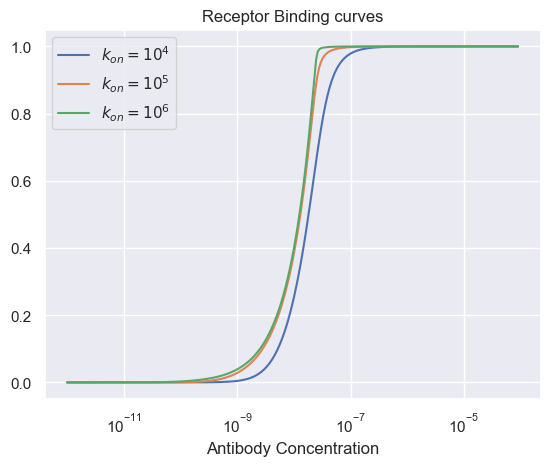

In [32]:
labels = [r'$k_{on} = 10^4$', r'$k_{on} = 10^5$', r'$k_{on} = 10^6$']
for i in range(len(r_vals)):
    plt.plot(A0s, r_vals[i], label = labels[i])

plt.xscale('log')
plt.legend(loc='best')
plt.title('Receptor Binding curves')
plt.xlabel('Antibody Concentration')
plt.show()

(10, 10)


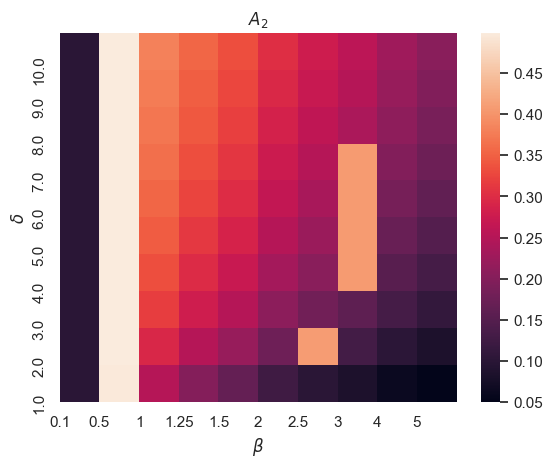

In [33]:
deltas = np.linspace(1, 10, 10)
betas = [0.1, 0.5, 1, 1.25, 1.5, 2, 2.5,  3, 4, 5]

def dimensionless_model1(z, A0, delta1, beta1):
    k = kon*A0
    alpha = k/koff
    dA1 = 2*alpha*(1-z[0]-2*z[1])*(beta1-z[0]-z[1]) - gamma*z[0] - delta1*alpha*(1-z[0]-2*z[1])*z[0] + 2*gamma*z[1]
    dA2 = delta1*alpha*(1-z[0]-2*z[1])*z[0] - 2*gamma*z[1]

    return [dA1, dA2]

def heatmap_vals_A1(delta1, beta1, A0):

    roots = fsolve(dimensionless_model1, [0.2, 0.2], args = (A0, delta1, beta1))

    return roots[0]

def heatmap_vals_A2(delta1, beta1, A0):

    roots = fsolve(dimensionless_model1, [0.2, 0.2], args = (A0, delta1, beta1))

    return roots[1]

X, Y = np.meshgrid(deltas, betas)

A1s = np.ones((len(deltas), len(betas)))

for i in range(len(deltas)):
    for j in range(len(betas)):
        A1s[i][j] = heatmap_vals_A2(deltas[i], betas[j], 1e-5)

print(A1s.shape)

fig, ax = plt.subplots()
sns.heatmap(A1s, yticklabels=True, xticklabels=True, ax=ax)
ax.set_title(r'$A_2$')
ax.invert_yaxis()
ax.set_ylabel(r'$\delta$')
ax.set_xlabel(r'$\beta$')
ax.set_xticks(range(len(deltas)))
ax.set_yticks(range(len(deltas)))
ax.set_yticklabels(deltas)
ax.set_xticklabels(betas)
plt.show()

In [34]:
alpha = k/koff
def jacobian(x):
    f1 = 2*alpha*(-1-beta+2*x[0]+3*x[1]) - 1 - delta*alpha*(1-2*x[0]-2*x[1])
    f2 = 2*alpha*(-1+x[0]-2*beta+2*x[0]+4*x[1])  + 2*delta*alpha*x[0] + 2
    f3 = delta*alpha*(1-2*x[0]-2*x[1])
    f4 = -2*delta*alpha*x[0] - 2

    return [[f1, f2],
             [f3, f4]]

roots = fsolve(dimensionless_model, [0.2, 0.2], args = (1e-5, 4, 100))
print(roots)
print(np.linalg.eig(jacobian(roots)))

TypeError: 'float' object is not subscriptable

In [ ]:
beta = 1
delta = 4
A1 = Symbol('A1')
express = 2*alpha*(1-A1 - 2*(delta*alpha*(1-A1)*A1)/(2*(1+delta*alpha*A1)))*(beta-A1-(delta*alpha*(1-A1)*A1)/(2*(1+delta*alpha*A1))) - A1 - delta*alpha*(1-A1-2*(delta*alpha*(1-A1)*A1)/(2*(1+delta*alpha*A1)))*A1 + 2*(delta*alpha*(1-A1)*A1)/(2*(1+delta*alpha*A1))

vals = solveset(express, A1)


In [ ]:
print(vals)

{-0.999999937468731, -0.00050000012487525, -0.00025, 0.33333327092694}


single cell binding model plot of nullclines

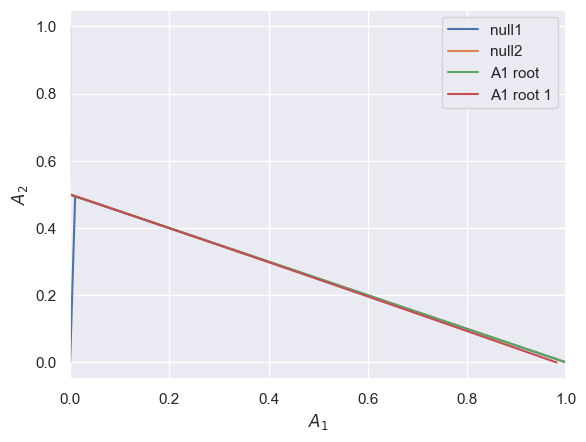

In [ ]:
kon = 1e5
Ainit = 1e-5
k = kon*Ainit
alpha = k/koff
Target_cell_number = 5e3
Atot = 1e16*Ainit/Target_cell_number
beta = Atot/rtot
delta = 4


def null1(x):

    return (delta*alpha*(1-x)*x)/(2*(1+delta*alpha*x))

def null2(x):
    return (2*alpha*beta*(1-x) - x - delta*alpha*(1-x)*x)/(2*(2*alpha*beta - 1 - delta*alpha*x))

def A1root(x):

    return 0.5*(1-2*x + ((2*x - 1)**2 - (8/(delta*alpha))*x)**(0.5))

def A1root1(x):

    return ((2*delta*alpha*x - 2*alpha*beta - 1 - delta*alpha) + (((2*alpha*beta + 1 + delta*alpha - 2*delta*alpha*x)**2 - 4*delta*alpha*(4*alpha*beta*x - 2*alpha*beta - 2*x))**(0.5)))/(2*delta*alpha)

def nan_to_zero(vals):
    array = np.zeros_like(vals)
    for i in range(len(vals)):
        if vals[i] == nan:
            array[i] == 0
        else: array[i] = vals[i]
    
    return array

A1s = np.linspace(0, 1, 100)

plt.plot(A1s, null1(A1s), label = 'null1')
plt.plot(A1s, null2(A1s), label = 'null2')
plt.plot(A1root(A1s), A1s, label = 'A1 root')
plt.plot(A1root1(A1s), A1s, label = 'A1 root 1')
plt.legend()
plt.xlabel(r'$A_1$')
plt.ylabel(r'$A_2$')
plt.xlim([0, 1])
plt.show()

In [38]:
Ainit = 1e-6
koff = 1e-4
kon = 1e5
rho = 1
k = kon*Ainit*rho
alpha = k/koff
Target_cell_number = 5e3
Atot = 1e16*Ainit/Target_cell_number
beta = Atot/rtot
delta = 100
print(beta)

t_end = 10
t = np.geomspace(1e-10, t_end, 5000)
tspan = [1e-10, t_end]
z0 = [0, 0]

20.0


In [39]:
def dimensionless_model(t, z):
    dA1 = 2*alpha*(1-z[0]-2*z[1])*(beta-z[0]-z[1]) - z[0] - delta*alpha*(1-z[0]-2*z[1])*z[0] + 2*z[1]
    dA2 = delta*alpha*(1-z[0]-2*z[1])*z[0] - 2*z[1]

    return [dA1, dA2]

Standard model without Ab surplus assumption phaseplane

/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_21075/1324275366.py:38: RuntimeWarning: invalid value encountered in sqrt
  return 0.5*((1-2*x) + (((2*x - 1)**2) - (8/(delta*alpha)*x))**(0.5))
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_21075/1324275366.py:41: RuntimeWarning: invalid value encountered in sqrt
  return 0.5*((1-2*x) - (((2*x - 1)**2) - (8/(delta*alpha)*x))**(0.5))
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_21075/1324275366.py:44: RuntimeWarning: invalid value encountered in sqrt
  return (1/(2*(alpha*(2+delta))))*(-(2*alpha*(-1 - beta + 3*x) - 1 - delta*alpha*(1 - 2*x)) + (((2*alpha*(-1 - beta + 3*x) - 1 - delta*alpha*(1 - 2*x))**2) - 4*(alpha*(2+delta))*(2*alpha*(beta - x - 2*beta*x + 2*(x**2)) + 2*x))**(0.5))
/var/folders/qf/lh9kspxj3zx7v12f8f3xdfbw0000gn/T/ipykernel_21075/1324275366.py:47: RuntimeWarning: invalid value encountered in sqrt
  return (1/(2*(alpha*(2+delta))))*(-(2*alpha*(-1 - beta + 3*x) - 1 - delta*alpha*(1 - 2*

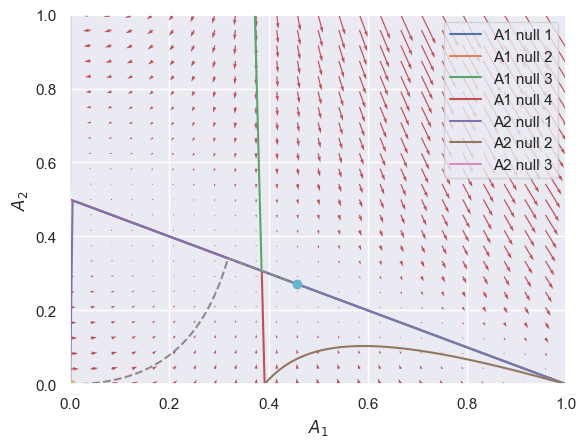

In [40]:
z = solve_ivp(dimensionless_model, tspan, z0, method='Radau', t_eval=t)

y1 = np.linspace(0, 1, 25)
y2 = np.linspace(0, 1, 25)

Y1, Y2 = np.meshgrid(y1, y2)

t = 0

A1, A2 = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape

for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = dimensionless_model(t, [x, y])
        A1[i, j] = yprime[0]
        A2[i, j] = yprime[1]


def A2_null1(x):

    return (delta*alpha*(1-x)*x)/(2*(1+delta*alpha*x))

def A2_null2(x):

    return 0.5*(-((1/2)*(3*x - 1 - beta) + (delta/2)*x + (1/(2*alpha))) + ((((1/2)*(3*x - 1 - beta) + (delta/2)*x + (1/(2*alpha)))**2) - 4*((1/2)*(beta - x - beta*x + x**2) - (x/(4*alpha)) - (delta/4)*(x - x**2)))**(1/2))

def A2_null3(x):
    return 0.5*(-((1/2)*(3*x - 1 - beta) + (delta/2)*x + (1/(2*alpha))) - ((((1/2)*(3*x - 1 - beta) + (delta/2)*x + (1/(2*alpha)))**2) - 4*((1/2)*(beta - x - beta*x + x**2) - (x/(4*alpha)) - (delta/4)*(x - x**2)))**(1/2))

A1s = np.linspace(0, 1, 200)


def A1_null1(x):
    return 0.5*((1-2*x) + (((2*x - 1)**2) - (8/(delta*alpha)*x))**(0.5))

def A1_null2(x):
    return 0.5*((1-2*x) - (((2*x - 1)**2) - (8/(delta*alpha)*x))**(0.5))

def A1_null3(x):
    return (1/(2*(alpha*(2+delta))))*(-(2*alpha*(-1 - beta + 3*x) - 1 - delta*alpha*(1 - 2*x)) + (((2*alpha*(-1 - beta + 3*x) - 1 - delta*alpha*(1 - 2*x))**2) - 4*(alpha*(2+delta))*(2*alpha*(beta - x - 2*beta*x + 2*(x**2)) + 2*x))**(0.5))

def A1_null4(x):
    return (1/(2*(alpha*(2+delta))))*(-(2*alpha*(-1 - beta + 3*x) - 1 - delta*alpha*(1 - 2*x)) - (((2*alpha*(-1 - beta + 3*x) - 1 - delta*alpha*(1 - 2*x))**2) - 4*(alpha*(2+delta))*(2*alpha*(beta - x - 2*beta*x + 2*(x**2)) + 2*x))**(0.5))


A2s = np.linspace(0, 1, 200)
Q = plt.quiver(Y1, Y2, A1, A2, color='r')

plt.plot(A1_null1(A2s), A2s, label='A1 null 1')
plt.plot(A1_null2(A2s), A2s, label='A1 null 2')
plt.plot(A1_null3(A2s), A2s, label='A1 null 3')
plt.plot(A1_null4(A2s), A2s, label='A1 null 4')
plt.plot(A1s, A2_null1(A1s), label='A2 null 1')
plt.plot(A1s, A2_null2(A1s), label='A2 null 2')
plt.plot(A1s, A2_null3(A1s), label='A2 null 3')
z1 = z.y[0]
z2 = z.y[1]
plt.plot(z1, z2, '--')
plt.plot([z1[0]], [z2[0]], 'o')
plt.plot([z1[-1]], [z2[-1]], 'o')
plt.xlabel(r'$A_1$')
plt.ylabel(r'$A_2$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()